In [1]:
import tensorflow as tf

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        depth = tf.cast(tf.shape(k)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)

        if mask is not None:
            logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # apply sin to even indices in the array; 2i
        sines = tf.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        cosines = tf.cos(angle_rads[:, 1::2])

        # interleave sines and cosines
        pos_encoding = tf.reshape(tf.concat([sines, cosines], axis=-1), shape=(1, position, d_model))

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention, _ = MultiHeadAttention(d_model, num_heads)(inputs, inputs, inputs, padding_mask)
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    outputs = tf.keras.layers.Dense(units)(attention)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name=f"encoder_layer_{i}")([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1, _ = MultiHeadAttention(d_model, num_heads)(inputs, inputs, inputs, look_ahead_mask)
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    attention2, _ = MultiHeadAttention(d_model, num_heads)(attention1, enc_outputs, enc_outputs, padding_mask)
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name=f'decoder_layer_{i}')([outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

def create_padding_mask(seq):
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    mask = tf.expand_dims(mask, axis=1)
    return mask

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    # Used in decoder's first multi-head attention block for masking future tokens
    look_ahead_mask = tf.keras.layers.Lambda(
        lambda x: create_look_ahead_mask(tf.shape(x)[1]),
        output_shape=(1, None, None),
        name='look_ahead_mask'
    )(dec_inputs)
    # The dec_padding_mask is for the second multi-head attention block in the decoder.
    # This mask is used to mask the encoder outputs.
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)

    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)([inputs, enc_padding_mask])

    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)([dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

# Parameters
vocab_size = 10000  # Example vocabulary size
num_layers = 4
units = 512
d_model = 512  # Make sure this matches with the 'units' if they need to be the same
num_heads = 8
dropout = 0.1

# Create Transformer model
transformer_model = transformer(
    vocab_size=vocab_size,
    num_layers=num_layers,
    units=units,
    d_model=d_model,
    num_heads=num_heads,
    dropout=dropout
)

transformer_model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 512)            1038131   ['inputs[0][0]',              
                                                          2          'enc_padding_mask[0

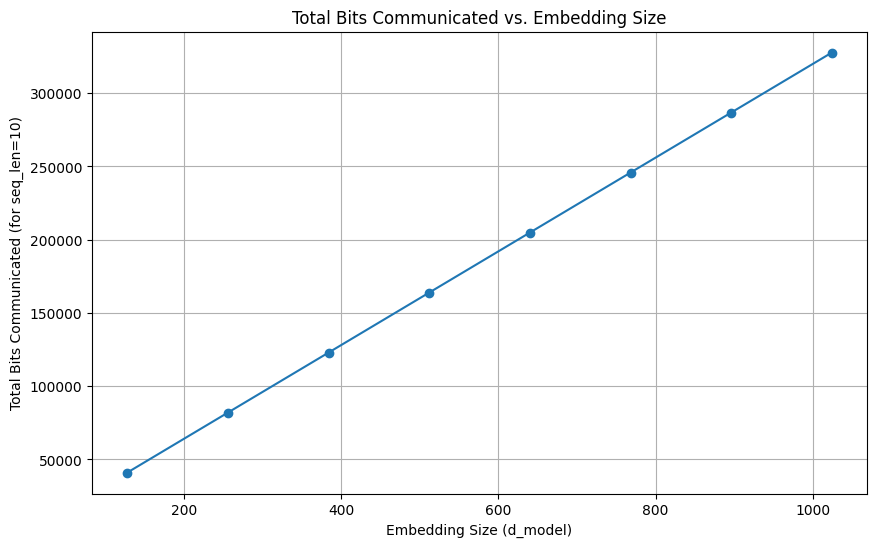

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming a sequence length of 10
seq_len = 10
# Let's consider a range of embedding sizes
embedding_sizes = np.arange(128, 1025, 128)
# Calculate the total number of bits for each embedding size
total_bits = embedding_sizes * 32 * seq_len

plt.figure(figsize=(10, 6))
plt.plot(embedding_sizes, total_bits, marker='o')
plt.title('Total Bits Communicated vs. Embedding Size')
plt.xlabel('Embedding Size (d_model)')
plt.ylabel('Total Bits Communicated (for seq_len=10)')
plt.grid(True)
plt.show()